In [204]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 엑셀 파일에서 데이터 읽어오기
df = pd.read_excel('data/2019_2022_diff_12.xlsx', sheet_name='Sheet1')
print(df.dtypes)


datetime           object
nearSeasonName     object
cct               float64
Unnamed: 3         object
dtype: object


In [205]:
# 날짜(datetime) 정규화
datetime_dt = pd.to_datetime(df['datetime'])
grouped = df.groupby(datetime_dt.dt.date)
first_time = pd.to_datetime(grouped['datetime'].transform('min'))
last_time = pd.to_datetime(grouped['datetime'].transform('max'))

df['normalized_time'] = (datetime_dt - first_time) / (last_time - first_time)

# 절기(season) 원-핫 인코딩
one_hot_encoded_season = pd.get_dummies(df['nearSeasonName'], prefix='nearSeasonName')
# print(one_hot_encoded_season.iloc[71147])
# 색온도(temperature) 정규화
scaler = MinMaxScaler()
df['normalized_temperature'] = scaler.fit_transform(df['cct'].values.reshape(-1, 1))


In [206]:
# 입력 데이터(X)와 출력 데이터(y) 준비
X = pd.concat([df['normalized_time'], one_hot_encoded_season], axis=1).values
y = df['normalized_temperature'].values

# 데이터셋 크기 조정 (시퀀스 길이에 맞게 조정)
sequence_length = 5  # 시퀀스 길이를 5로 설정
X_seq, y_seq = [], []
for i in range(len(X) - sequence_length):
    X_seq.append(X[i:i+sequence_length])
    y_seq.append(y[i+sequence_length])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# 데이터셋 분할
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)


# LSTM 모델 구성
# model = Sequential()
# model.add(LSTM(3, input_shape=(sequence_length, X_train.shape[2]), activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(1))

# model.compile(optimizer='adam', loss='mean_squared_error')

model = Sequential()
model.add(LSTM(16, input_shape=(sequence_length, X_train.shape[2]), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


# 모델 학습
model.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
4957/4957 [==============================] - 15s 2ms/step - loss: 0.0057
Epoch 2/50
4957/4957 [==============================] - 10s 2ms/step - loss: 0.0045
Epoch 3/50
4957/4957 [==============================] - 10s 2ms/step - loss: 0.0045
Epoch 4/50
4957/4957 [==============================] - 10s 2ms/step - loss: 0.0044
Epoch 5/50
4957/4957 [==============================] - 9s 2ms/step - loss: 0.0044
Epoch 6/50
4957/4957 [==============================] - 9s 2ms/step - loss: 0.0044
Epoch 7/50
4957/4957 [==============================] - 10s 2ms/step - loss: 0.0044
Epoch 8/50
4957/4957 [==============================] - 9s 2ms/step - loss: 0.0044
Epoch 9/50
4957/4957 [==============================] - 10s 2ms/step - loss: 0.0044
Epoch 10/50
4957/4957 [==============================] - 10s 2ms/step - loss: 0.0044
Epoch 11/50
4957/4957 [==============================] - 9s 2ms/step - loss: 0.0044
Epoch 12/50
4957/4957 [==============================] - 10s 2ms/step - loss: 

In [207]:
predictions = model.predict(X_val)

1240/1240 [==============================] - 2s 994us/step


In [208]:
# model.save('lstm_model_2019_2021.h5')
model.save('lstm_model_2019_2022_diff_12.h5')

In [236]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_val, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, predictions)

In [237]:
print(mse)
print(rmse)
print(mae)

0.004283669081312098
0.06544974470012926
0.039928916602277674


In [238]:
# 엑셀 파일에서 데이터 읽어오기
# df_test = pd.read_excel('data/20200512_test_data.xlsx', sheet_name='Sheet1')


In [239]:
# print(X[175347])

test_data = X[153835-2:154525-2+1,:]
print(test_data)
test_data_y = y[153835-2:154525-2+1]
print(len(test_data_y))
X_seq_test, y_seq_test = [], []
for i in range(len(test_data) - sequence_length):
    X_seq_test.append(test_data[i:i+sequence_length])
    y_seq_test.append(test_data_y[i+sequence_length])
X_seq_test = np.array(X_seq_test)
y_seq_test = np.array(y_seq_test)
predictions_test = model.predict(X_seq_test)
print(len(predictions_test))

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.00143682 0.         0.         ... 0.         0.         0.        ]
 [0.00287363 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.99710242 0.         0.         ... 0.         0.         0.        ]
 [0.99853924 0.         0.         ... 0.         0.         0.        ]
 [1.         0.         0.         ... 0.         0.         0.        ]]
691
22/22 [==============================] - 1s 14ms/step
686


In [240]:
mse_test = mean_squared_error(y_seq_test, predictions_test)
rmse_test = np.sqrt(mse)
mae_test = mean_absolute_error(y_seq_test, predictions_test)

print(mse_test)
print(rmse_test)
print(mae_test)

0.0013295779358078292
0.06544974470012926
0.02122141069121583


In [241]:
restored_cct = scaler.inverse_transform(predictions_test)

In [242]:
print(restored_cct)

[[4086.371 ]
 [4094.1208]
 [4101.931 ]
 [4109.7734]
 [4117.4985]
 [4128.687 ]
 [4144.595 ]
 [4168.117 ]
 [4191.2446]
 [4214.151 ]
 [4236.97  ]
 [4260.0693]
 [4282.5854]
 [4304.868 ]
 [4326.5825]
 [4347.904 ]
 [4368.6533]
 [4389.3813]
 [4409.796 ]
 [4429.6973]
 [4449.1084]
 [4468.2627]
 [4487.3706]
 [4487.3706]
 [4487.3706]
 [4500.0635]
 [4522.885 ]
 [4545.355 ]
 [4567.792 ]
 [4589.8823]
 [4611.94  ]
 [4633.655 ]
 [4657.3994]
 [4680.928 ]
 [4695.228 ]
 [4705.347 ]
 [4714.395 ]
 [4723.308 ]
 [4732.2085]
 [4740.976 ]
 [4749.731 ]
 [4758.3545]
 [4766.9653]
 [4775.446 ]
 [4783.9136]
 [4792.2534]
 [4800.579 ]
 [4808.7793]
 [4816.965 ]
 [4825.0264]
 [4834.433 ]
 [4844.1436]
 [4853.9937]
 [4863.619 ]
 [4873.194 ]
 [4882.61  ]
 [4891.9277]
 [4901.2056]
 [4910.3657]
 [4919.497 ]
 [4928.505 ]
 [4937.4917]
 [4946.346 ]
 [4955.18  ]
 [4963.884 ]
 [4972.565 ]
 [4981.118 ]
 [4989.649 ]
 [4998.0527]
 [5006.4336]
 [5014.69  ]
 [5022.9224]
 [5031.0317]
 [5039.117 ]
 [5047.0806]
 [5054.956 ]
 [5062.807 ]

686
686


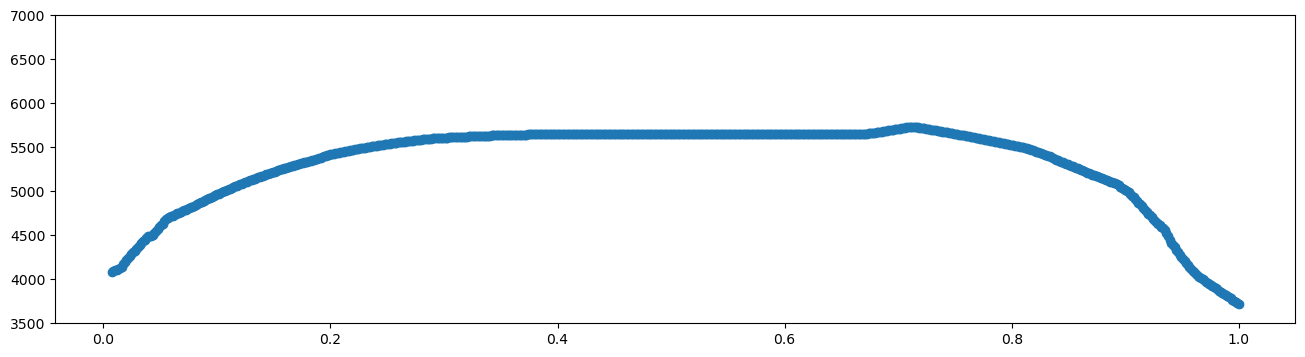

In [243]:
import matplotlib.pyplot as plt

print(len(X[153835-2+5:154525-2+1,0]))
print(len(restored_cct))
plt.figure(figsize=(16,4))
plt.scatter(X[153835-2+5:154525-2+1,0],restored_cct)
plt.ylim([3500,7000])
plt.show()

In [244]:

import datetime
# 최소 시간과 최대 시간
min_time_str = "2021-09-11 06:41:11" # 155853
max_time_str = "2021-09-11 18:17:10" # 156543

# 최소 시간과 최대 시간을 datetime 객체로 변환
min_time = datetime.datetime.strptime(min_time_str, "%Y-%m-%d %H:%M:%S")
max_time = datetime.datetime.strptime(max_time_str, "%Y-%m-%d %H:%M:%S")

# 1초 단위로 시간을 증가시키며 변환
converted_times = []
normalized_times =X[153835-2+5:154525-2+1, 0]
times = min_time + (max_time - min_time) * normalized_times
times_str = [time.strftime("%Y-%m-%d %H:%M:%S") for time in times]

# 변환된 시간 출력
print(times_str)

['2021-09-11 06:46:13', '2021-09-11 06:47:13', '2021-09-11 06:48:14', '2021-09-11 06:49:14', '2021-09-11 06:50:17', '2021-09-11 06:51:17', '2021-09-11 06:52:18', '2021-09-11 06:53:18', '2021-09-11 06:54:18', '2021-09-11 06:55:19', '2021-09-11 06:56:22', '2021-09-11 06:57:22', '2021-09-11 06:58:23', '2021-09-11 06:59:23', '2021-09-11 07:00:24', '2021-09-11 07:01:24', '2021-09-11 07:02:25', '2021-09-11 07:03:25', '2021-09-11 07:04:25', '2021-09-11 07:05:26', '2021-09-11 07:06:26', '2021-09-11 07:07:27', '2021-09-11 07:08:27', '2021-09-11 07:09:28', '2021-09-11 07:10:28', '2021-09-11 07:11:29', '2021-09-11 07:12:29', '2021-09-11 07:13:30', '2021-09-11 07:14:30', '2021-09-11 07:15:31', '2021-09-11 07:16:31', '2021-09-11 07:17:32', '2021-09-11 07:18:32', '2021-09-11 07:19:33', '2021-09-11 07:20:33', '2021-09-11 07:21:34', '2021-09-11 07:22:34', '2021-09-11 07:23:35', '2021-09-11 07:24:35', '2021-09-11 07:25:36', '2021-09-11 07:26:36', '2021-09-11 07:27:37', '2021-09-11 07:28:37', '2021-09-1

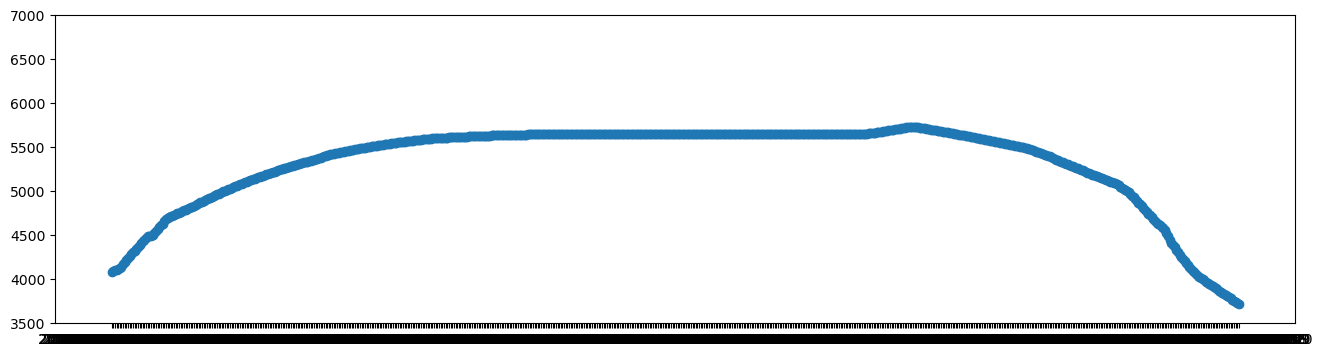

In [245]:
plt.figure(figsize=(16,4))
plt.scatter(times_str,restored_cct)
plt.ylim([3500,7000])
plt.show()

In [246]:
data = pd.read_excel('data/test.xlsx', sheet_name = '2021-09-11')
time_cct_dict = dict(zip(data['datetime'], data['cct']))

In [247]:
from collections import deque
import csv
anomaly_dict = {}
# file = open('data/diff_data.csv','w',newline='')
# wr = csv.writer(file)


def sliding_window(dict, window_size):
    window = deque(maxlen = window_size)  # deque를 사용하여 윈도우 생성 (deque : 스택과 큐의 기능을 모두 지원하는 양방향 큐)
    

    for i, (time, cct) in enumerate(dict.items()):
        window.append(cct) # 윈도우에 추가
        if(i == 0):
            if(cct > 4000 ):
                anomaly_process(i, time,cct)
            else:
                normal_process(i)
            continue
                

#         if len(window) == window_size:  # 윈도우가 최대 크기에 도달한 경우
#             avg = sum(window) / window_size  # 평균 구하기
#             diff = abs(window[-1] - avg)  # 마지막 값과 평균과의 차이 구하기
#             diff_ratio = (diff / avg) * 100 # 오차율
#             if avg >= 3000 and avg < 4000 :
#                 if diff_ratio > 2.0:
#                     anomaly_process(i, time, cct)
#                 else:
#                     normal_process(i)
#             elif avg >= 4000 and avg < 5000:
#                 if diff_ratio > 1.5:
#                     anomaly_process(i, time, cct)
#                 else:
#                     normal_process(i)
#             elif avg >= 5000 and avg < 6000:
#                 if(diff_ratio > 1.0):
#                     anomaly_process(i, time, cct)
#                 else:
#                     normal_process(i)
#             else :
#                 normal_process(i)


        
        avg = sum(window) / len(window)  # 평균 구하기
        diff = abs(window[-1] - avg)  # 마지막 값과 평균과의 차이 구하기
        diff_ratio = (diff / avg) * 100 # 오차율
        # wr.writerow([avg,diff,diff_ratio])
        if avg >= 3000 and avg < 4000 :
            if diff_ratio > 2.0:
                anomaly_process(i, time, cct)
            else:
                normal_process(i)
        elif avg >= 4000 and avg < 5000:
            if diff_ratio > 1.5:
                anomaly_process(i, time, cct)
            else:
                normal_process(i)
        elif avg >= 5000 and avg < 6000:
            if(diff_ratio > 1.0):
                anomaly_process(i, time, cct)
            else:
                normal_process(i)
        else :
            #normal_process(i)
            anomaly_process(i, time, cct)
#     file.close()    
    return 0

is_anomaly_list = []

def anomaly_process(i, time, cct):
    anomaly_dict[time] = cct
    is_anomaly_list.append(True)


def normal_process(i):
    is_anomaly_list.append(False)

In [248]:
sliding_window(time_cct_dict,5)

0

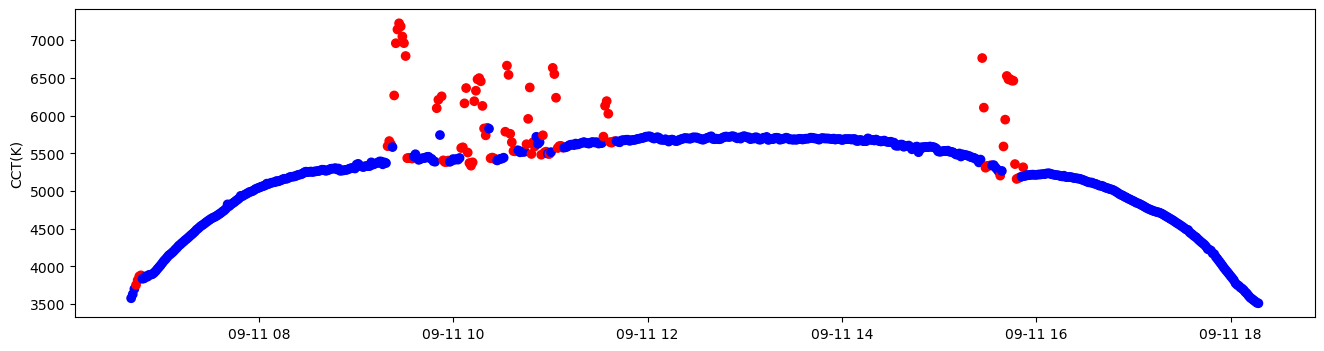

100


In [249]:
import matplotlib.pyplot as plt

colors = ['red' if anomaly else 'blue' for anomaly in is_anomaly_list]
plt.figure(figsize=(16,4))
plt.scatter(data['datetime'], data['cct'], color = colors)
plt.ylabel("CCT(K)")
# plt.savefig('plt_20200512.png')
plt.show()
print(sum(is_anomaly_list))

In [250]:
# 절기별 색온도 추세와 비교하여 이상치 탐지
# 20년 5월 12일은 입하

import datetime

timestamp_minute = [time.timestamp() / 60 for time in time_cct_dict.keys()]
min_timestamp = min(timestamp_minute)
max_timestamp = max(timestamp_minute)

normalized_dict = {}
for time, cct in time_cct_dict.items():
    timestamp = time.timestamp() / 60
    normalized_key = (timestamp - min_timestamp) / (max_timestamp - min_timestamp)
    normalized_dict[normalized_key] = cct
    
for time, cct in normalized_dict.items():
    print(f"{time}: {cct}")

0.0: 3578.08970157201
0.0014368160157071377: 3630.76689759191
0.0028736320314142754: 3701.23163145821
0.004334394979289184: 3753.79363611908
0.005771210994996321: 3816.76139020037
0.007231973942871229: 3867.92049400447
0.008668789958578367: 3881.74916732461
0.010129552911805832: 3836.51789207634
0.01156636892751297: 3841.70626056808
0.013075025745075975: 3869.39391541404
0.014511841760783113: 3863.88655561522
0.01597260470865802: 3888.44354257273
0.017409420724365157: 3890.22784363537
0.018846236740072297: 3896.71339748941
0.020306999687947205: 3914.19150304642
0.02181565650551021: 3937.6961253601
0.023252472521217347: 3964.33993295108
0.024713235469092255: 3989.40615007884
0.026150051484799392: 4014.98760728384
0.0276108144326743: 4043.27624703812
0.029047630448381438: 4072.05865428918
0.030508393401608904: 4094.47825903905
0.03194520941731604: 4120.40912709045
0.033382025433023176: 4146.47635496091
0.03484278838089808: 4162.45111600695
0.03627960439660523: 4180.55792028369
0.03774036

In [251]:
data_solar_term = pd.read_excel('data/solar_term.xlsx', sheet_name = '백로')
solar_term_dict = dict(zip(data_solar_term['time'], data_solar_term['회귀식+평균']))

In [252]:
min_difference = float('inf')  # 초기값을 무한대로 설정
closest_temperature = None
solar_term_diff_dict = {}
for time1, temperature1 in normalized_dict.items():
    closest_time = None
    min_difference = float('inf')  # 초기값을 무한대로 설정
    closest_temperature = None
    
    for time2, temperature2 in solar_term_dict.items():
        difference = abs(time1 - time2)
        if difference < min_difference:
            min_difference = difference
            closest_time = time2
            closest_temperature = temperature2
    
    if closest_time is not None:
        print(f"시간: {time1}, 가장 가까운 시간: {closest_time}, 가장 가까운 시간의 색온도: {closest_temperature}")
        solar_term_diff_dict[time1]=round(((abs(temperature1-closest_temperature)/closest_temperature)*100),1)
    else:
        print(f"시간: {time1}, 가장 가까운 시간이 없습니다.")

시간: 0.0, 가장 가까운 시간: 0.0, 가장 가까운 시간의 색온도: 3743.291267809104
시간: 0.0014368160157071377, 가장 가까운 시간: 0.001436781609195402, 가장 가까운 시간의 색온도: 3765.4277331914564
시간: 0.0028736320314142754, 가장 가까운 시간: 0.002873563218390805, 가장 가까운 시간의 색온도: 3787.375753725778
시간: 0.004334394979289184, 가장 가까운 시간: 0.004310344827586207, 가장 가까운 시간의 색온도: 3809.1364101876948
시간: 0.005771210994996321, 가장 가까운 시간: 0.005747126436781609, 가장 가까운 시간의 색온도: 3830.710780210183
시간: 0.007231973942871229, 가장 가까운 시간: 0.007183908045977011, 가장 가까운 시간의 색온도: 3852.0999382835626
시간: 0.008668789958578367, 가장 가까운 시간: 0.008620689655172414, 가장 가까운 시간의 색온도: 3873.3049557554987
시간: 0.010129552911805832, 가장 가까운 시간: 0.01005747126436782, 가장 가까운 시간의 색온도: 3894.3269008310044
시간: 0.01156636892751297, 가장 가까운 시간: 0.01149425287356322, 가장 가까운 시간의 색온도: 3915.166838572438
시간: 0.013075025745075975, 가장 가까운 시간: 0.01293103448275862, 가장 가까운 시간의 색온도: 3935.8258308995037
시간: 0.014511841760783113, 가장 가까운 시간: 0.01436781609195402, 가장 가까운 시간의 색온도: 3956.304936589252
시간: 0.01

In [253]:
for i, (time, diff_ratio) in enumerate(solar_term_diff_dict.items()):
    if(diff_ratio > 5):
        is_anomaly_list[i] = True

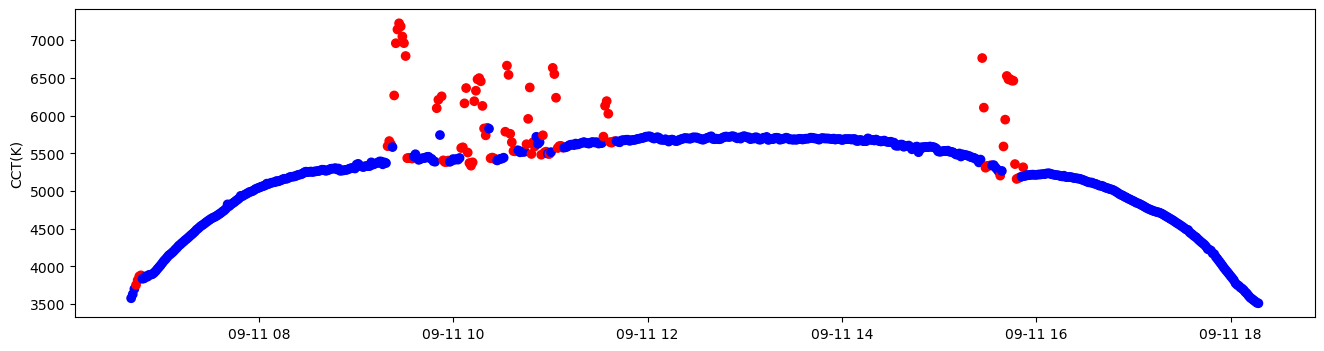

691
100


In [254]:
colors = ['red' if anomaly else 'blue' for anomaly in is_anomaly_list]
plt.figure(figsize=(16,4))
plt.scatter(data['datetime'], data['cct'], color = colors)
plt.ylabel("CCT(K)")
# plt.savefig('plt_20200512_solar_term.png')
plt.show()

print(len(data['cct']))
print(sum(is_anomaly_list))

In [255]:

restored_time_cct = dict(zip(times,restored_cct))
# print(restored_time_cct)
print(len(restored_time_cct))

686


In [256]:
print((list(map(str,restored_time_cct.keys()))[0]))

replace_cct = np.copy(data['cct'])


# for time1, temperature1 in normalized_dict.items():
#     closest_time = None
#     min_difference = float('inf')  # 초기값을 무한대로 설정
#     closest_temperature = None
    
#     for time2, temperature2 in solar_term_dict.items():
#         difference = abs(time1 - time2)
#         if difference < min_difference:
#             min_difference = difference
#             closest_time = time2
#             closest_temperature = temperature2
    
#     if closest_time is not None:
#         print(f"시간: {time1}, 가장 가까운 시간: {closest_time}, 가장 가까운 시간의 색온도: {closest_temperature}")
#         solar_term_diff_dict[time1]=round(((abs(temperature1-closest_temperature)/closest_temperature)*100),1)
#     else:
#         print(f"시간: {time1}, 가장 가까운 시간이 없습니다.")
        
# # print(data['datetime'][0])
# closest_time_2 = None
# closest_time_diff_2 = float('inf')


# for i, is_anomaly in enumerate(is_anomaly_list):
#     if is_anomaly:
#         for j, time in enumerate(restored_time_cct.keys()):
#             time_diff = abs(time-data['datetime'][i])
#             time_diff = datetime.timedelta.total_seconds(time_diff)
#             if time_diff < closest_time_diff_2:
#                 closest_time_diff_2 = time_diff
#                 closest_time_2 = time
#                 replace_cct[i] = restored_time_cct[closest_time_2]

for i, is_anomaly in enumerate(is_anomaly_list):
    if i>5 and is_anomaly:
        replace_cct[i]=restored_cct[i-5]


2021-09-11 06:46:13


In [257]:
# print(replace_cct)
result = np.array_equal(replace_cct, data['cct'])
print(result)

False


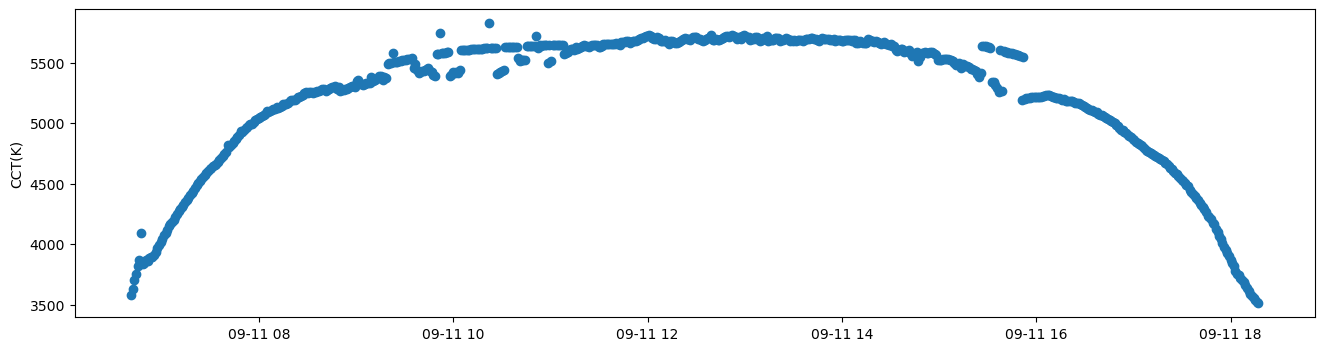

In [258]:
plt.figure(figsize=(16,4))
plt.scatter(data['datetime'], replace_cct)
plt.ylabel("CCT(K)")
plt.savefig('plt_220210911_replace_anomaly.png')
plt.show()

In [259]:
print(is_anomaly_list)
print(data['datetime'][3])

[False, False, False, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, Fa

In [260]:
print(restored_time_cct.keys())

dict_keys([datetime.datetime(2021, 9, 11, 6, 46, 13), datetime.datetime(2021, 9, 11, 6, 47, 13), datetime.datetime(2021, 9, 11, 6, 48, 14), datetime.datetime(2021, 9, 11, 6, 49, 14), datetime.datetime(2021, 9, 11, 6, 50, 17), datetime.datetime(2021, 9, 11, 6, 51, 17), datetime.datetime(2021, 9, 11, 6, 52, 18), datetime.datetime(2021, 9, 11, 6, 53, 18), datetime.datetime(2021, 9, 11, 6, 54, 18), datetime.datetime(2021, 9, 11, 6, 55, 19), datetime.datetime(2021, 9, 11, 6, 56, 22), datetime.datetime(2021, 9, 11, 6, 57, 22), datetime.datetime(2021, 9, 11, 6, 58, 23), datetime.datetime(2021, 9, 11, 6, 59, 23), datetime.datetime(2021, 9, 11, 7, 0, 24), datetime.datetime(2021, 9, 11, 7, 1, 24), datetime.datetime(2021, 9, 11, 7, 2, 25), datetime.datetime(2021, 9, 11, 7, 3, 25), datetime.datetime(2021, 9, 11, 7, 4, 25), datetime.datetime(2021, 9, 11, 7, 5, 26), datetime.datetime(2021, 9, 11, 7, 6, 26), datetime.datetime(2021, 9, 11, 7, 7, 27), datetime.datetime(2021, 9, 11, 7, 8, 27), datetime.

In [261]:
# datetime_cct_df = df[['datetime','cct']]
# print(datetime_cct_df)

In [262]:
# grouped_dfs = []
# for _, group in datetime_cct_df.groupby(datetime_cct_df.df['datetime'].dt.date)